## HSQC fitting

# Module import 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from scipy.optimize import curve_fit
plt.ion()
from sklearn.linear_model import LinearRegression
import math
from matplotlib import rc, rcParams
from mpl_toolkits.mplot3d import Axes3D 
from scipy import stats

# Parameters input:

In [19]:
m_lig = 51.7 #mass of material (extracted lignin/ cell wall) in mg
m_PS = 7.1 #mass of polystyrene standard in mg
MW_lig = #molecular weight of polystyrene standard  repetiing unit 
MW_PS = 102  #molecular weight of polystyrene standard  repetiing unit 


# Functions generation:

In [20]:
# Generate a list of local maxima based on neighbouring intensity. The output is sorted in descending intensity order.
def detect_local_maxima(data, x_names, y_names, threshold = 0):
    local_max = []
    for j in range(1, data.shape[1] - 1):
        for i in range(1, data.shape[0] - 1):
            middle = data[i][j]
            top = data[i][j - 1]
            bottom = data[i][j + 1]
            left = data[i - 1][j]
            right = data[i + 1][j]
            if (middle > top and
                middle > bottom and
                middle > left and
                middle > right and
                middle > threshold):
                # (intensity, x_index, y_index)
                local_max += [(middle, i, j, x_names[j], y_names[i] )]
    local_max = sorted(local_max)
    local_max.reverse()
    return local_max

# 2D Gaussian function with independent components.
def gauss2d(Z, A, mu_x, mu_y, sigma_x, sigma_y):
    x = np.array(Z[0])
    y = np.array(Z[1])
    x_exp = np.exp(-0.5 * ((x - mu_x)/sigma_x) ** 2)
    y_exp = np.exp(-0.5 * ((y - mu_y)/sigma_y) ** 2)
    ret = (A * x_exp * y_exp)
    return ret.ravel()

def calculate_r2(X, Y, Z, popt):
    Z_fit = gauss2d((X, Y), popt[0], popt[1], popt[2], popt[3], popt[4])
    Z = Z.ravel()
    residuals = Z - Z_fit
    print (residuals)
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((Z - np.mean(Z)) ** 2)
    print(ss_tot, ss_res)
    R2 = 1 -(ss_res / ss_tot)
    return R2

def calculate_r2_2(X, Y, Z, params):
    Z_fit = gauss2d_2((X, Y), *popt)
    Z = Z.ravel()
    residuals = Z - Z_fit
    print('residuals', residuals)
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((Z - np.mean(Z)) ** 2)
    print(ss_tot, ss_res)
    R2 = 1 -(ss_res / ss_tot)
    return R2

def gauss_1d_x (x, A, x_0, sigma_x):
  C =  A*(1/(sigma_x*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-x_0)/sigma_x)**2)))
  return C #return the gaussian fitting 


# 2D Gaussian function with overlapping.
def gauss2d_2(Z, A, mu_x, mu_y, sigma_x, sigma_y, B, mu_x_2, mu_y_2, sigma_x_2, sigma_y_2):
    x = np.array(Z[0])
    y = np.array(Z[1])
    x_exp = np.exp(-0.5 * ((x - mu_x)/sigma_x) ** 2) 
    x_exp_2 = np.exp(-0.5 * ((x - mu_x_2)/sigma_x_2) ** 2)
    y_exp = np.exp(-0.5 * ((y - mu_y)/sigma_y) ** 2)
    y_exp_2 = np.exp(-0.5 * ((y - mu_y_2)/sigma_y_2) ** 2)
    ret = (A * x_exp * y_exp + B * x_exp_2 * y_exp_2)
    return ret.ravel()



# Data loading:   

In [31]:
#Loading the three HSQC text file previously extracted witg rbnmr or NMRpipe
data_1 = pd.read_csv('/Users/xxx/Documents/nmr/Birch_1/1/pdata/1/Data.txt', sep='\t', header=None) #HSQC_1
data_2 = pd.read_csv('/Users/xxx/Documents/nmr/Birch_1/2/pdata/1/Data.txt', sep='\t', header=None) #HSQC_2
data_3 = pd.read_csv('/Users/xxx/Documents/nmr/Birch_1/2/pdata/1/Data.txt', sep='\t', header=None) #HSQC_3
x = pd.read_csv('/Users/xxx/Documents/nmr/Birch_1/2/pdata/1/X.txt', sep = "\t",  header=None) #x axis - 1H (ppm)
y = pd.read_csv('/Users/xxx/Documents/nmr/Birch_1/2/pdata/1/Y.txt', sep = "\t", header=None) #y axis - 1H (ppm)

Data_1 = data_1.values 
Data_2 = data_2.values
Data_3 = data_3.values
data = [] #creating one big data set with three spectra
data.append(Data_1)
data.append(Data_2)
data.append(Data_3)

X = x.values
Y = y.values
x_names = X.flatten()
y_names = Y.flatten()

# Preliminary results:

In [32]:
# Plot a 2D image of the matrix
hfont = {'fontname':'Arial'}
ax = plt.pcolormesh(x_names, y_names, data_1, vmin=-10., vmax=10., shading='auto', cmap='hsv')
ax = plt.axes()
ax.invert_xaxis()
ax.invert_yaxis()
ax.yaxis.tick_right()
ax.text('1H (ppm)', '13C (ppm)', 'Intensity')
plt.xlabel('1H (ppm)', **hfont)
plt.ylabel('13C (ppm)', **hfont)
plt.show()

[950036.8587627411, 315711.8355560303, 112851.80962753296]
Intensity
> mean:  [950036.8587627411, 315711.8355560303, 112851.80962753296]
> max:  183740000.0
> min:  -3110800.0
> std:  1907334.6108908392


<ipython-input-32-26b318dba01a>:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


ConversionError: Failed to convert value(s) to axis units: '1H (ppm)'

<Figure size 432x288 with 1 Axes>

# Data processing

# Extract peaks of interest out of the NMR spectra

In [ ]:
results = []
HSQC = np.array([1,2,3])

for h in range (0, (len(data)), 1): 
  data_df = pd.DataFrame(data[h], columns=x_names, index=y_names)  #Open HSQC spectra successively 
  print("Detecting local maxima")
  local_max = detect_local_maxima(data[h], x_names, y_names, 1e3)
  print("> found: ", len(local_max))
  #print (local_max)
  
  #Create as many lists of indexes as peaks you want to analyse 
  ind_PS = [] #standard peak
  ind_Alpha = [] #B-O-4 alpha peak
  ind_Beta = [] #B-O-4 alpha peak
  ind_acetal = [] #B-O-4 aldehyde protected peak (if you study extracted lignin...)
    
  for k in range (0, len(local_max)): #look for our peaks of interest: alpha, beta, gamma, acetal, IS 
  #specify in which region (x_up, x_down, y_up, y_down) you can find your peak of interest.
  #do it for all the peaks defined above
    if (local_max[k][4] >= y_down and local_max[k][4] <= y_up and local_max[k][3] >= x_down and local_max[k][3] <= x_up):
      ind_Alpha.append(k)
    elif (local_max[k][4] >= 39 and local_max[k][4] <= 43 and local_max[k][3] >= 1.7 and local_max[k][3] <= 2.3): 
      ind_PS.append(k)
  print('PS', ind_PS, 'Alpha', ind_Alpha, 'Beta', ind_Beta)


  #Select the highest local maxima as the peak to be fitted for each peak of interest
  #Do it if the region you have specified is big and several peaks have been found
  int_Alpha = [local_max[q][0] for q in ind_Alpha]
  max_a = np.max(int_Alpha)
  index_a = np.where(int_Alpha == max_a)
  index_a = index_a[0]
  print(index_a)
  ind.append(ind_Alpha[index_a[0]])

  int_Beta = [local_max[q][0] for q in ind_Beta]
  max_b = np.max(int_Beta)
  index_b = np.where(int_Beta == max_b)
  index_b = index_b[0]
  ind.append(ind_Beta[index_b[0]])

  #Always put the standard as last item of the list
  int_PS = [local_max[q][0] for q in ind_PS]
  max_PS = np.max(int_PS)
  index_PS = np.where(int_Apo == max_PS)
  index_PS = index_PS[0]
  ind.append(ind_PS[index_PS[0]])

  print(ind)

  candidate_peaks=[]
  candidate_peaks = list([local_max[ind[0]], local_max[ind[1]], local_max[ind[2]], local_max[ind[3]], local_max[ind[4]]])
  #Generate the final list of peaks we will work on
  print(candidate_peaks)

# Analysis and gaussian fitting of local maxima: extracting peaks data

In [ ]:
# Start the analysis of the selected N local maxima.
# Define a window we will work on to fit the peak
  roi_n_samples_x_min = [[6, 6, 6, 6, 6], [6, 6, 6, 6, 6], [6, 6, 6, 6, 6]]  
  roi_n_samples_x_max = [[6, 6, 6, 6, 6], [6, 6, 6, 6, 6], [6, 6, 6, 6, 6]]
  roi_n_samples_y = [6, 6, 6, 6, 6]

    
  #Confidence interval
  ci = 0.95
  # Convert to percentile point of the normal distribution.
  # See: https://en.wikipedia.org/wiki/Standard_score
  pp = (1. + ci) / 2.
  # Convert to number of standard deviations.
  nstd = stats.norm.ppf(pp)
  print (nstd)
  
  plt.close('all')
  plt.ioff()
  fitted_params = []
  param_names = [
    "local_max_x",
    "local_max_y",
    "local_max_intensity",
    "fitted_height",
    "fitted_x",
    "fitted_y",
    "fitted_sigma_x",
    "fitted_sigma_y",
    "fitted_volume",
    "fit_R2"]
  
  for (k, candidate) in enumerate(candidate_peaks):
    intensity, i, j, x_h, y_c = candidate
    x0 = data_df.columns[j]
    y0 = data_df.index[i]
    print(k)

    # Calculate the region of interest (ROI) for this candidate peak
    min_x = j - roi_n_samples_x_min[h][k]
    max_x = j + roi_n_samples_x_max[h][k]
    min_y = i - roi_n_samples_y[k]
    max_y = i + roi_n_samples_y[k]
    peak_data = data_df.iloc[min_y:max_y, min_x:max_x] #ROI
    print(peak_data)
    peak_data_red = data_df.iloc[min_y:max_y, min_x:max_x]

    # Prepare the parameter matrix for curve fit.
    x_values = peak_data.columns
    y_values = peak_data.index
    print(x_values)
    X, Y = np.meshgrid(x_values, y_values)

    # Initial fit parameters.
    p0 = (intensity, x0, y0, 0.01, 0.05)
    print(p0)

    # The bounds can be used to constrain each parameter fitting to a range.
    tol_x = 0.5
    tol_y = 0.5
    bounds = (
        (1e3, x0 - tol_x, y0 - tol_y, 0.001, 0.01),
        (1e12, x0 + tol_x, y0 + tol_y, 1, 50)
        )
        
    # If fitting fails for this candidate peak, we move on to the next one.
    try: # Do the thing!
      popt, pcov = curve_fit(gauss2d, (X, Y), peak_data_red.values.ravel(), p0=p0, bounds=bounds)
      print(popt)
      # Standard deviation errors on the parameters.
      perr = np.sqrt(np.diag(pcov))
      # Add nstd standard deviations to parameters to obtain the upper confidence interval.
      popt_up = popt + nstd * perr
      popt_dw = popt - nstd * perr
      print ('Up', popt_up)
      print ('Down', popt_dw)
    except:
      print('Failed')
      continue
    
    # Prepare the fitted data for a contour plotting. We use 100 points for higher resolution of circles, which looks nicer.
    x_fit = np.linspace(np.min(x_values), np.max(x_values), 100)
    y_fit = np.linspace(np.min(y_values), np.max(y_values), 100)
    X_fit, Y_fit = np.meshgrid(x_fit, y_fit)
    #peak_data_fit = gauss2d((X_fit, Y_fit), *popt).reshape(100, 100)
    peak_data_fit = gauss2d_2((X_fit, Y_fit), *popt).reshape(100, 100)

     Calculate volume.
    fit_height, fit_x0, fit_y0, fit_sigma_x, fit_sigma_y, fit_height_2, fit_x0_2, fit_y0_2, fit_sigma_x_2, fit_sigma_y_2) = popt
    fit_volume = fit_height * fit_sigma_x * fit_sigma_y * 2.0 * np.pi + 0.5*fit_height_2 * fit_sigma_x_2 * fit_sigma_y_2 * 2.0 * np.pi
        
    # Calculate R2, but only within N * sigma in each direction, since multiple peaks may appear in the ROI.
    n_sig_x = 4 #adapt the value based on your data
    n_sig_y = 300
    x_index = ((peak_data.columns > x0 - fit_sigma_x * n_sig_x) &
                (peak_data.columns < x0 + fit_sigma_x * n_sig_x))
    y_index = ((peak_data.index > y0 - fit_sigma_y * n_sig_y) &
               (peak_data.index < y0 + fit_sigma_y * n_sig_y))
        

    x_r2 = peak_data.columns[x_index]
    y_r2 = peak_data.index[y_index]
    X_r2, Y_r2 = np.meshgrid(x_r2, y_r2)
    Z_r2 = peak_data_red.iloc[y_index, x_index]

   # peak_data
   fit_r2 = calculate_r2_2(X_r2, Y_r2, Z_r2.values, popt)
   fitted_params = [(h+1), x0, y0, intensity, popt[0], popt[1], popt[2], popt[3], popt[4], fit_volume, np.log(fit_volume), fit_r2, popt_up[0], popt_up[1], popt_up[2], popt_up[3], popt_up[4], popt_down[0], popt_down[1], popt_down[2], popt_down[3], popt_down[4]] #, fit_r2)]
   print(fitted_params)
   results.append(fitted_params)

## Data plotting: 2D / 3D with corresponding fit. 

   # Plot the candidate peaks in 2D and the corresponding fit.
    fig = plt.figure()
    ax = plt.axes()
    ax.pcolormesh(peak_data.columns, peak_data.index, peak_data, shading='auto')
    ax.contour(X_fit, Y_fit, peak_data_fit, 5, colors='w', alpha=0.8)
    ax.invert_xaxis()
    ax.invert_yaxis()
    rc('axes', linewidth=2)
    rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
    ax.yaxis.tick_right()
    plt.xlabel('1H (ppm)', **hfont, fontweight='bold')
    plt.ylabel('13C (ppm)', **hfont, fontweight='bold')
    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
    
    

    fig3d = plt.figure()
    ax3d = plt.axes(projection='3d')
    ax3d.contour3D(X_fit, Y_fit, peak_data_fit, 50, cmap='summer')
    #ax3d.plot_surface(peak_data.columns, peak_data.index, peak_data, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    #ax3d.plot_wireframe(X, Y, peak_data, color='red')
    #ax3d.contour3D(X, Y, peak_data_red.values, 50, cmap='summer')
    ax3d.plot_wireframe(X, Y, peak_data_red.values, color='red')
    rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
    
    plt.xlabel('1H (ppm)', **hfont, fontweight='bold')
    plt.ylabel('13C (ppm)', **hfont, fontweight='bold')
    
    # Save plots do disk.
    plt.title("HSQC: {} x: {}  y: {}  int: {} R2: {:2f}".format((h+1), x0, y0, intensity, fit_r2))
    fig_name = "{}_{}_{}.png".format(h, x0, y0)
    plt.savefig(fig_name, dpi=300)
    #plt.close(fig)

    

# Saving data

In [ ]:
# Save fitted peak parameters to disk.
param_names = ['h', 'x0', 'y0', 'Intensity', 'A', 'mu_x', 'mu_y', 'sigma_x', 'sigma_y', 'volume', 'ln(V)', 'r2','A', 'mu_x', 'mu_y', 'sigma_x', 'sigma_y', 'A', 'mu_x', 'mu_y', 'sigma_x', 'sigma_y','V0', 'BO4']
print(results)

# Processing extracted data

Detecting local maxima
> found:  915
PS [16, 65, 130, 181, 209] Alpha [98, 562] Beta [83] Gamma [81] Ace [10, 464]
[0]
[98, 83, 81, 10, 16]
[(18167000.0, 527, 614, 4.857, 72.5), (22600000.0, 484, 619, 4.7927, 79.436), (22997000.0, 591, 584, 5.2427, 62.176), (183110000.0, 196, 446, 7.0173, 125.89), (123610000.0, 725, 850, 1.8222, 40.56)]
1.959963984540054
0
           4.9598     4.9470     4.9341     4.9213      4.9084      4.8955  \
73.468  2079700.0  2297700.0  2482600.0  2777700.0   3331800.0   3961600.0   
73.306  2619800.0  3016800.0  3361100.0  3862900.0   4754800.0   5810800.0   
73.145  3256600.0  3878800.0  4422200.0  5149000.0   6397200.0   7940200.0   
72.984  3900900.0  4768000.0  5525700.0  6460700.0   8026200.0  10055000.0   
72.822  4448300.0  5543500.0  6500800.0  7594400.0   9384800.0  11826000.0   
72.661  4800800.0  6069600.0  7181800.0  8361300.0  10245000.0  12956000.0   
72.500  4889500.0  6246000.0  7445300.0  8628500.0  10461000.0  13249000.0   
72.338  4690600.0

<ipython-input-33-489249f7435d>:292: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
<ipython-input-33-489249f7435d>:308: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


1
           4.8955     4.8827      4.8698      4.8570      4.8441      4.8312  \
80.404  2932500.0  3048400.0   3590800.0   4590100.0   5459700.0   5767400.0   
80.243  3782200.0  4125100.0   4952800.0   6321600.0   7563100.0   8176200.0   
80.081  4797600.0  5430000.0   6606700.0   8432700.0  10129000.0  11102000.0   
79.920  5860400.0  6808600.0   8350900.0  10661000.0  12839000.0  14186000.0   
79.759  6815300.0  8057100.0   9921100.0  12663000.0  15276000.0  16962000.0   
79.597  7502700.0  8966200.0  11049000.0  14091000.0  17017000.0  18955000.0   
79.436  7795400.0  9370300.0  11525000.0  14677000.0  17735000.0  19797000.0   
79.275  7630700.0  9188500.0  11254000.0  14300000.0  17281000.0  19321000.0   
79.113  7026200.0  8445400.0  10276000.0  13016000.0  15723000.0  17598000.0   
78.952  6075700.0  7265000.0   8757300.0  11045000.0  13327000.0  14923000.0   
78.791  4926400.0  5839500.0   6950300.0   8712000.0  10486000.0  11739000.0   
78.629  3744000.0  4382700.0   5129100

<ipython-input-33-489249f7435d>:292: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
<ipython-input-33-489249f7435d>:308: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


2
           5.3456     5.3327      5.3199      5.3070      5.2942      5.2813  \
63.144  5726900.0  7663400.0   8825000.0   9121900.0   9581200.0  11329000.0   
62.982  6273100.0  8546500.0  10002000.0  10486000.0  11084000.0  13079000.0   
62.821  6563900.0  9090600.0  10865000.0  11625000.0  12380000.0  14497000.0   
62.660  6590700.0  9264700.0  11356000.0  12465000.0  13390000.0  15493000.0   
62.498  6376800.0  9084000.0  11455000.0  12947000.0  14044000.0  16012000.0   
62.337  5967500.0  8598500.0  11174000.0  13031000.0  14285000.0  16028000.0   
62.176  5418000.0  7878200.0  10550000.0  12695000.0  14071000.0  15539000.0   
62.014  4781800.0  6998000.0   9637600.0  11946000.0  13387000.0  14569000.0   
61.853  4104400.0  6027800.0   8503000.0  10823000.0  12259000.0  13171000.0   
61.692  3421700.0  5027900.0   7224900.0   9405900.0  10759000.0  11433000.0   
61.531  2761600.0  4049200.0   5889300.0   7807000.0   9006500.0   9477400.0   
61.369  2147200.0  3135200.0   4585300

<ipython-input-33-489249f7435d>:292: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
<ipython-input-33-489249f7435d>:308: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


3
             7.0944       7.0816       7.0687       7.0558       7.0430  \
126.86   20961000.0   25111000.0   27871000.0   28184000.0   27107000.0   
126.70   34532000.0   40919000.0   44665000.0   44558000.0   42469000.0   
126.54   55987000.0   66563000.0   72698000.0   72894000.0   70403000.0   
126.38   79314000.0   95021000.0  104430000.0  105700000.0  103650000.0   
126.22   99032000.0  119660000.0  132510000.0  135430000.0  134640000.0   
126.05  111170000.0  135470000.0  151180000.0  155970000.0  157020000.0   
125.89  113810000.0  139810000.0  157200000.0  163660000.0  166710000.0   
125.73  107090000.0  132550000.0  150130000.0  157710000.0  162500000.0   
125.57   92818000.0  115700000.0  131980000.0  139920000.0  145840000.0   
125.41   73883000.0   92706000.0  106500000.0  113990000.0  120270000.0   
125.25   53492000.0   67529000.0   78137000.0   84518000.0   90399000.0   
125.09   34523000.0   43822000.0   51098000.0   55975000.0   60860000.0   

             7.0301   

<ipython-input-33-489249f7435d>:292: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
<ipython-input-33-489249f7435d>:308: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


4
            1.8994      1.8865      1.8737       1.8608       1.8480  \
41.528   9805000.0  11677000.0  13645000.0   15405000.0   16705000.0   
41.367  17948000.0  21480000.0  25357000.0   28955000.0   31732000.0   
41.205  28119000.0  33714000.0  39980000.0   45882000.0   50535000.0   
41.044  39159000.0  46981000.0  55849000.0   64261000.0   70979000.0   
40.883  49490000.0  59379000.0  70685000.0   81455000.0   90135000.0   
40.721  57433000.0  68887000.0  82071000.0   94665000.0  104880000.0   
40.560  61597000.0  73836000.0  88007000.0  101570000.0  112640000.0   
40.399  61221000.0  73320000.0  87406000.0  100910000.0  111990000.0   
40.237  56368000.0  67422000.0  80365000.0   92796000.0  103030000.0   
40.076  47907000.0  57196000.0  68143000.0   78674000.0   87364000.0   
39.915  37296000.0  44403000.0  52847000.0   60978000.0   67700000.0   
39.754  26227000.0  31080000.0  36911000.0   42528000.0   47167000.0   

             1.8351       1.8222       1.8094       1.7965   

<ipython-input-33-489249f7435d>:292: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
<ipython-input-33-489249f7435d>:308: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


Detecting local maxima
> found:  3695
PS [21, 77, 139, 181, 230, 382] Alpha [87, 594, 628, 770, 899] Beta [76] Gamma [88, 1746] Ace [12]
[0]
[87, 76, 88, 12, 21]
[(7371400.0, 527, 613, 4.8698, 72.5), (8296700.0, 484, 618, 4.8055, 79.436), (7343700.0, 591, 584, 5.2427, 62.176), (51260000.0, 197, 446, 7.0173, 125.73), (35651000.0, 725, 850, 1.8222, 40.56)]
1.959963984540054
0
           4.9727     4.9598     4.9470     4.9341     4.9213     4.9084  \
73.468   754850.0   944940.0  1105300.0  1183000.0  1200700.0  1337100.0   
73.306   871410.0  1081400.0  1321600.0  1525000.0  1681400.0  1968100.0   
73.145  1024200.0  1262500.0  1594400.0  1937000.0  2242900.0  2691900.0   
72.984  1184600.0  1459700.0  1885800.0  2363400.0  2808600.0  3407100.0   
72.822  1318400.0  1635000.0  2144500.0  2733400.0  3288900.0  4000800.0   
72.661  1393700.0  1749800.0  2317100.0  2976700.0  3600000.0  4372300.0   
72.500  1388200.0  1773200.0  2361500.0  3040100.0  3682700.0  4456000.0   
72.338  1294000

<ipython-input-33-489249f7435d>:292: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
<ipython-input-33-489249f7435d>:308: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


1
           4.9084     4.8955     4.8827     4.8698     4.8570     4.8441  \
80.404   665720.0   821590.0  1155600.0  1355200.0  1496100.0  1780600.0   
80.243   861830.0  1135500.0  1572600.0  1858400.0  2116600.0  2561600.0   
80.081  1109300.0  1524200.0  2077600.0  2471600.0  2886400.0  3521900.0   
79.920  1382300.0  1943900.0  2611700.0  3122400.0  3712700.0  4544300.0   
79.759  1643200.0  2335000.0  3097400.0  3713500.0  4469500.0  5473700.0   
79.597  1850400.0  2634800.0  3454400.0  4143800.0  5025900.0  6151100.0   
79.436  1967700.0  2791000.0  3618000.0  4332700.0  5277600.0  6452700.0   
79.275  1973700.0  2774500.0  3555200.0  4240700.0  5174100.0  6320300.0   
79.113  1867200.0  2586600.0  3272900.0  3880100.0  4732000.0  5776800.0   
78.952  1667500.0  2258600.0  2816300.0  3312100.0  4030200.0  4919200.0   
78.791  1409500.0  1843800.0  2258100.0  2631700.0  3190400.0  3893600.0   
78.629  1135200.0  1405400.0  1681000.0  1944400.0  2345900.0  2859200.0   

         

<ipython-input-33-489249f7435d>:292: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
<ipython-input-33-489249f7435d>:308: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


2
           5.3456     5.3327     5.3199     5.3070     5.2942     5.2813  \
63.144  1797400.0  2484000.0  2848200.0  2900100.0  3172000.0  3940100.0   
62.982  1998800.0  2759100.0  3210600.0  3323700.0  3633600.0  4491700.0   
62.821  2116500.0  2924400.0  3471900.0  3671300.0  4003700.0  4890400.0   
62.660  2147100.0  2972700.0  3615900.0  3919600.0  4257800.0  5108000.0   
62.498  2098100.0  2909600.0  3636200.0  4050500.0  4379500.0  5136900.0   
62.337  1983800.0  2749500.0  3534400.0  4050200.0  4359600.0  4986600.0   
62.176  1821400.0  2510800.0  3317300.0  3910700.0  4195200.0  4678200.0   
62.014  1627000.0  2212900.0  2997600.0  3632700.0  3891300.0  4240000.0   
61.853  1413500.0  1875100.0  2594400.0  3228700.0  3462700.0  3703800.0   
61.692  1191200.0  1517100.0  2134400.0  2725600.0  2936200.0  3104500.0   
61.531   968440.0  1160200.0  1652100.0  2164400.0  2350700.0  2479100.0   
61.369   753620.0   826990.0  1186800.0  1595500.0  1754100.0  1866600.0   

         

<ipython-input-33-489249f7435d>:292: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
<ipython-input-33-489249f7435d>:308: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


3
            7.0944      7.0816      7.0687      7.0558      7.0430  \
126.70   9063400.0  10542000.0  11213000.0  10936000.0  10282000.0   
126.54  15705000.0  18396000.0  19702000.0  19431000.0  18636000.0   
126.38  22816000.0  26988000.0  29178000.0  29142000.0  28469000.0   
126.22  28771000.0  34372000.0  37510000.0  37900000.0  37604000.0   
126.05  32415000.0  39104000.0  43057000.0  43971000.0  44230000.0   
125.89  33206000.0  40440000.0  44912000.0  46334000.0  47205000.0   
125.73  31209000.0  38365000.0  42968000.0  44774000.0  46185000.0   
125.57  26982000.0  33482000.0  37817000.0  39812000.0  41587000.0   
125.41  21381000.0  26795000.0  30531000.0  32497000.0  34405000.0   
125.25  15355000.0  19457000.0  22386000.0  24132000.0  25943000.0   
125.09   9752700.0  12530000.0  14587000.0  15986000.0  17519000.0   
124.93   5186900.0   6800100.0   8051300.0   9055200.0  10212000.0   

            7.0301      7.0173      7.0044      6.9915      6.9787  \
126.70   9840900.

<ipython-input-33-489249f7435d>:292: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
<ipython-input-33-489249f7435d>:308: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


4
            1.8994      1.8865      1.8737      1.8608      1.8480  \
41.528   3361300.0   3913500.0   4622600.0   5281000.0   5655600.0   
41.367   5854000.0   6922600.0   8192300.0   9350500.0  10108000.0   
41.205   8918500.0  10629000.0  12585000.0  14367000.0  15625000.0   
41.044  12196000.0  14594000.0  17284000.0  19747000.0  21569000.0   
40.883  15208000.0  18238000.0  21601000.0  24703000.0  27074000.0   
40.721  17457000.0  20956000.0  24820000.0  28414000.0  31231000.0   
40.560  18536000.0  22261000.0  26363000.0  30214000.0  33294000.0   
40.399  18238000.0  21902000.0  25936000.0  29756000.0  32870000.0   
40.237  16601000.0  19932000.0  23600000.0  27105000.0  30015000.0   
40.076  13906000.0  16692000.0  19761000.0  22720000.0  25225000.0   
39.915  10606000.0  12728000.0  15067000.0  17341000.0  19312000.0   
39.754   7216400.0   8660500.0  10253000.0  11811000.0  13205000.0   

            1.8351      1.8222      1.8094      1.7965      1.7837  \
41.528   5703200.

<ipython-input-33-489249f7435d>:292: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
<ipython-input-33-489249f7435d>:308: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


Detecting local maxima
> found:  12865
PS [29, 88, 166, 216, 271, 296, 314, 586, 1053, 1853] Alpha [78, 3468] Beta [81] Gamma [92, 520] Ace [20, 1557, 1921]
[0]
[78, 81, 92, 20, 29]
[(3214500.0, 527, 614, 4.857, 72.5), (3191700.0, 484, 619, 4.7927, 79.436), (2648500.0, 591, 584, 5.2427, 62.176), (14930000.0, 197, 446, 7.0173, 125.73), (10952000.0, 725, 850, 1.8222, 40.56)]
1.959963984540054
0
           4.8955     4.8827     4.8698     4.8570     4.8441     4.8312
73.468   469760.0   697040.0   909070.0   970760.0   998990.0  1121400.0
73.306   769660.0  1045800.0  1320500.0  1429400.0  1440200.0  1442000.0
73.145  1118700.0  1452100.0  1791000.0  1941100.0  1924000.0  1805900.0
72.984  1473000.0  1868900.0  2265800.0  2442100.0  2386400.0  2162700.0
72.822  1783100.0  2239900.0  2679900.0  2860600.0  2757700.0  2452500.0
72.661  2004000.0  2511100.0  2971200.0  3132500.0  2977700.0  2620800.0
72.500  2104500.0  2641900.0  3094500.0  3214500.0  3008600.0  2630900.0
72.338  2074100.0  2

<ipython-input-33-489249f7435d>:292: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
<ipython-input-33-489249f7435d>:308: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


1
           4.8184     4.8055     4.7927     4.7798
80.404   776880.0   940390.0   919090.0   747830.0
80.243  1142700.0  1285400.0  1250200.0  1047800.0
80.081  1583000.0  1727000.0  1686900.0  1442500.0
79.920  2044400.0  2210600.0  2176100.0  1886400.0
79.759  2457900.0  2660600.0  2642100.0  2314700.0
79.597  2753700.0  2997100.0  3003400.0  2656400.0
79.436  2878400.0  3155700.0  3191700.0  2849500.0
79.275  2808600.0  3103800.0  3168700.0  2856300.0
79.113  2556400.0  2848300.0  2935500.0  2672100.0
78.952  2166900.0  2433900.0  2531600.0  2326600.0
78.791  1706300.0  1931200.0  2024400.0  1876000.0
78.629  1246200.0  1418800.0  1492300.0  1390000.0
Float64Index([4.8184, 4.8055, 4.7927, 4.7798], dtype='float64')
(3191700.0, 4.7927, 79.436, 0.01, 0.05)
[3.22405044e+06 4.79894978e+00 7.93911705e+01 3.96299348e-02
 6.19547770e-01]
Up [3.26433528e+06 4.79977535e+00 7.93982655e+01 4.23598709e-02
 6.28452900e-01]
Down [3.18376560e+06 4.79812421e+00 7.93840755e+01 3.68999986e-02
 6.106

<ipython-input-33-489249f7435d>:292: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
<ipython-input-33-489249f7435d>:308: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


2
           5.2813     5.2684     5.2556     5.2427     5.2299     5.2170
63.144  1323500.0  1690600.0  1697000.0  1447900.0  1104500.0   750370.0
62.982  1497900.0  1904700.0  1960400.0  1719700.0  1338700.0   919060.0
62.821  1624800.0  2058800.0  2183500.0  1992100.0  1598700.0  1112400.0
62.660  1701600.0  2145400.0  2351000.0  2246800.0  1870000.0  1324700.0
62.498  1729400.0  2164200.0  2450900.0  2459300.0  2126000.0  1538700.0
62.337  1711500.0  2119800.0  2474300.0  2601800.0  2331900.0  1727300.0
62.176  1651500.0  2019300.0  2416300.0  2648500.0  2451400.0  1858300.0
62.014  1552900.0  1870600.0  2276800.0  2582100.0  2455900.0  1902300.0
61.853  1419600.0  1681600.0  2061400.0  2398400.0  2332400.0  1841000.0
61.692  1256700.0  1460700.0  1782400.0  2109100.0  2087700.0  1672600.0
61.531  1072200.0  1217300.0  1458400.0  1741200.0  1748400.0  1414100.0
61.369   876300.0   963020.0  1113300.0  1331900.0  1355100.0  1098000.0
Float64Index([5.2813, 5.2684, 5.2556, 5.2427, 5.2

<ipython-input-33-489249f7435d>:292: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
<ipython-input-33-489249f7435d>:308: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


3
            7.0430      7.0301      7.0173      7.0044
126.70   2903500.0   2675800.0   2342300.0   1869100.0
126.54   5259900.0   5101400.0   4775600.0   3994800.0
126.38   8108400.0   8114400.0   7857800.0   6734300.0
126.22  10816000.0  11053000.0  10917000.0   9488400.0
126.05  12848000.0  13340000.0  13358000.0  11721000.0
125.89  13857000.0  14580000.0  14759000.0  13047000.0
125.73  13722000.0  14610000.0  14930000.0  13283000.0
125.57  12537000.0  13501000.0  13918000.0  12457000.0
125.41  10572000.0  11512000.0  11971000.0  10777000.0
125.25   8190400.0   9024000.0   9463400.0   8568800.0
125.09   5773000.0   6444100.0   6813900.0   6201800.0
124.93   3640400.0   4129000.0   4395200.0   4013500.0
Float64Index([7.042999999999999, 7.0301, 7.0173, 7.0044], dtype='float64')
(14930000.0, 7.0173, 125.73, 0.01, 0.05)
[1.52320261e+07 7.02558405e+00 1.25778543e+02 4.34172720e-02
 5.25773626e-01]
Up [1.55511258e+07 7.02732145e+00 1.25788008e+02 4.94955749e-02
 5.36486777e-01]
Down [1.

<ipython-input-33-489249f7435d>:292: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
<ipython-input-33-489249f7435d>:308: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


4
           1.8865     1.8737     1.8608     1.8480      1.8351      1.8222  \
41.528  1216200.0  1389600.0  1555500.0  1756400.0   1888300.0   1775100.0   
41.367  2088100.0  2446800.0  2785400.0  3114600.0   3328400.0   3224200.0   
41.205  3169100.0  3754200.0  4293800.0  4774100.0   5096800.0   5030000.0   
41.044  4335800.0  5161500.0  5908200.0  6544100.0   6990700.0   6988400.0   
40.883  5420600.0  6465100.0  7395900.0  8169300.0   8737600.0   8819100.0   
40.721  6245500.0  7449700.0  8512200.0  9382900.0  10051000.0  10223000.0   
40.560  6663600.0  7938900.0  9057300.0  9968200.0  10698000.0  10952000.0   
40.399  6595000.0  7839000.0  8926700.0  9812800.0  10554000.0  10868000.0   
40.237  6048000.0  7163400.0  8138100.0  8938000.0   9638700.0   9979200.0   
40.076  5116500.0  6029700.0  6828100.0  7494300.0   8107200.0   8440200.0   
39.915  3957700.0  4631100.0  5218800.0  5724600.0   6216600.0   6510800.0   
39.754  2753400.0  3188700.0  3563800.0  3905700.0   4261400.0

<ipython-input-33-489249f7435d>:292: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
<ipython-input-33-489249f7435d>:308: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


[[1, 4.857, 72.5, 18167000.0, 16944539.801976692, 4.852957498955615, 72.51779692658234, 0.06352233189627851, 0.6453637676645922, 4364561.914262935, 15.289028378934557, 0.9606500330368868, 17259712.758673027, 4.854146497313502, 72.53013591684036, 0.0649837720623884, 0.6614941216408495, 16629366.845280359, 4.851768500597728, 72.5054579363243, 0.06206089173016862, 0.629233413688335], [1, 4.7927, 79.436, 22600000.0, 22493401.659398906, 4.80458338429588, 79.41156463066271, 0.057311076852569115, 0.6347980823710455, 5141728.984534866, 15.452899959183023, 0.9809780517608089, 22808158.84438113, 4.805366772557025, 79.42087810560125, 0.05821319675550044, 0.6467362999812747, 22178644.47441668, 4.803799996034734, 79.40225115572417, 0.05640895694963779, 0.6228598647608163], [1, 5.2427, 62.176, 22997000.0, 20804707.27988215, 5.254860037396831, 62.24922864361239, 0.053974600108160894, 0.8286470834265375, 5846561.434853429, 15.58136425747847, 0.8798627563653192, 21550946.040028997, 5.256671059164681, 6

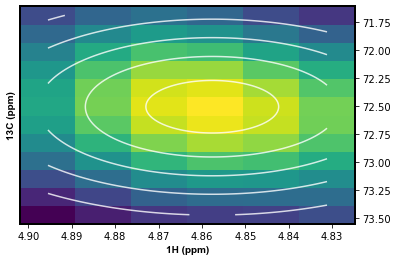

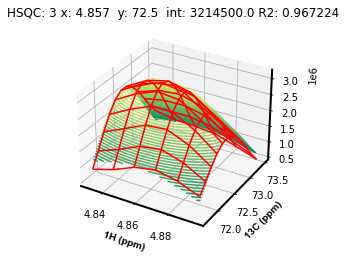

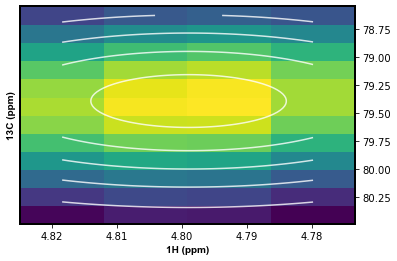

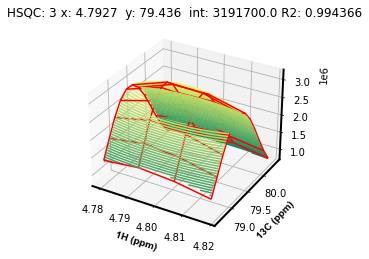

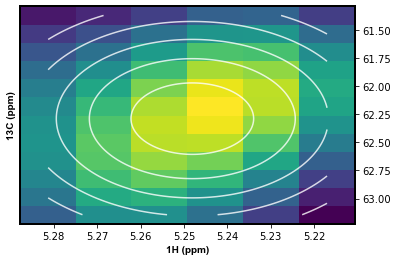

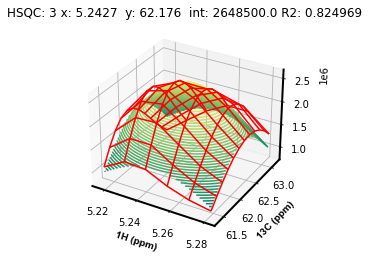

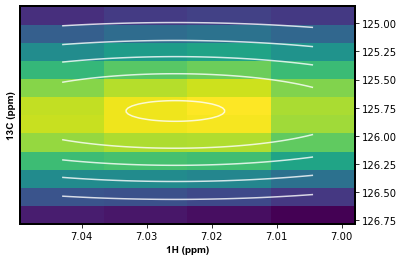

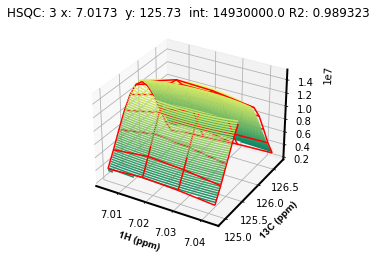

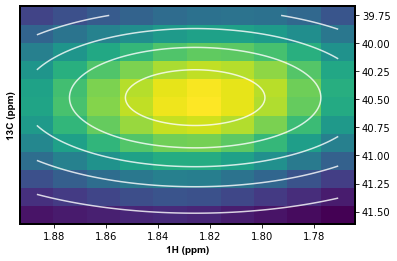

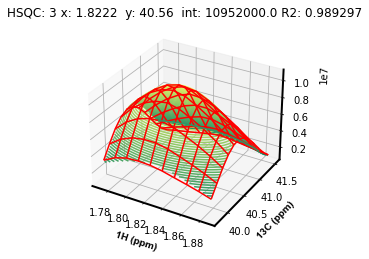

In [ ]:
# Analyse volume results
ln_V_0 = []
for n in range(1,6,1): 
    y = []
    for m in range (0, 3*x, 1): #Adapt this number based on the number x of peaks you fitted: you have 3 spectra and x peaks in each spectra
      if results[m][0] == n:
        y.append(results[m][10])
    ln_V_0.append(y)
print(ln_V_0)

V_0 = []
for p in range (0, x, 1): ): #Adapt this number based on the number x of peaks you fitted
  model = LinearRegression()
  y = np.array([ln_V_0[q][p] for q in range(0,3,1)])
  model.fit(HSQC.reshape(-1, 1), y.reshape(-1, 1))
  zero = model.intercept_
  V_0.append((zero))
print(V_0)


n_PS = m_PS / MW_PS #mole of polystyrene in the tube
n_BO4 = []  #mole of B-O-4 linkages in the tube
n_BO4_mass = [] #mole of B-O-4 linkages in the tube per g of lignin

for k in range (0, len(V_0) -1 ,1):
  n_BO4.append(n_PS*np.exp(V_0[k])/np.exp(V_0[k])) #k is the index corresponding to the PS peak
  n_BO4_mass.append((n_PS*np.exp(V_0[k])/np.exp(V_0[k]))/(m_lig*0.001)) #k is the index corresponding to the PS peak
print(n_BO4)
print('mass', n_BO4_mass)

for k in range (0, 4, 1):
    results[k].append(str(V_0[k]))
    results[k].append(str(n_BO4_mass[k]))
fitted_params_df = pd.DataFrame(results, columns=param_names)
fitted_params_df.to_csv("fitted_parameters.csv", index=False)